# init

In [1]:
# SETUP - change home_dir path to parent directory of this repo
import sys
home_dir = '/home/tim/Dropbox/' # home directory of repo for yours corresponding to github repo
sys.path.append(home_dir)
from data.data_methods import *
from supervised_learning.supervised_methods import *

# the numpy arrays need to match the same floating type used by pytorch here
th.set_default_dtype(th.float32)

# remove some annoying tensorflow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# set directory to write all results to
run_path = 'results/init/'
os.makedirs(run_path, exist_ok=True)

# set random seeds for replicability
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
th.manual_seed(random_seed)
if th.cuda.is_available():
    th.cuda.manual_seed_all(random_seed) 

# set file io
save_model_to = f'{run_path}model.pth'
save_evals_to = f'{run_path}evaluations.json'

# harware params
device = 'cuda:0'
pytorch_threads = 4 # scale this down with more active processes running at same time
num_workers = 2 # scale this down with RAM constraints
batch_size = 128 # scale this down with VRAM constraints
pin_memory = False # toggle on if training data is small enough to fit in VRAM

cpu count: 20
gpu count: 3
cuda avail: True


# prepare training and validation data

In [5]:
# read data
# SETUP - potentially change prepared_datasets_path path to yours
data = get_data(
    region='train', 
    sensor_names=['SceneV1', 'DepthV1'], 
    airsim_map='AirSimNH',
)
X = data['observations']['SceneV1']
Y = data['observations']['DepthV1']

# need to shuffle data before split, otherwise data is ordered from bottom left corner to top right corner of map
# read_shuffled_idxs=True to maintain static train/val splits
read_shuffled_idxs = True
shuffled_idxs_path = f'shuffled_idxs.p'
if read_shuffled_idxs and os.path.exists(shuffled_idxs_path):
    idxs = pk_read(shuffled_idxs_path)
else:
    idxs = [i for i in range(len(X))]
    random.shuffle(idxs)
    pk_write(idxs, shuffled_idxs_path)

# keep all data or sample from data
# takes a little under 14gb of RAM for all data
load_full = True
if load_full:
    n_val = 10_000
    X_train = X[idxs[n_val:]]
    Y_train = Y[idxs[n_val:]]     
    X_val = X[idxs[:n_val]]
    Y_val = Y[idxs[:n_val]]
else:
    n_train, n_val = 10_000, 10_000
    X_train = X[idxs[:n_train]]
    Y_train = Y[idxs[:n_train]]
    if n_val > 0:
        X_val = X[idxs[-1*n_val:]]
        Y_val = Y[idxs[-1*n_val:]]
    else:
        X_val = None
        Y_val = None
    del X, Y

# extract parameters from input/ouput data
n_instances = X_train.shape[0]
n_channels = X_train.shape[1]
n_dim1 = X_train.shape[2]
n_dim2 = X_train.shape[3]

print('Train shape:', X_train.shape, Y_train.shape)
print('Val shape:', X_val.shape, Y_val.shape)

Train shape: (97116, 3, 144, 256) (97116, 1, 144, 256)
Val shape: (1000, 3, 144, 256) (1000, 1, 144, 256)


# process params

In [6]:
X_mean = 94.11807077041952 #np.mean(X_train)
X_std = 80.77841523336176 #np.std(X_train)
Y_min = 0
Y_max = 255

def x_preproc_func(x, _mean, _std):
    return (x.astype(np.float32)-_mean)/_std
def y_preproc_func(y, _min, _max):
    return (y.astype(np.float32)-_min)/(_max-_min)
x_preproc_params={'_mean':X_mean, '_std':X_std}
y_preproc_params={'_min':Y_min, '_max':Y_max}
def unprocess_func(p, _min, _max):
    p = (p*(_max-_min)+_min).astype(np.uint8)
    p[p==0] = 1
    return p
unprocess_params={'_min':Y_min, '_max':Y_max}

# set model architecture

In [7]:
# DGNLNet https://ieeexplore.ieee.org/abstract/document/9318521
# make a scalable CNN following Zixia's depth network inspired from above
scale = 1 # scales number of channels in each layer
model_func = create_cnn
model_params = {
    'block_layers':[
            [
                [nn.Conv2d, {'in_channels':n_channels, 'out_channels':int(32*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(32*scale)}],
                [nn.SELU],
            ],
            [
                [nn.Conv2d, {'in_channels':int(32*scale), 'out_channels':int(64*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(64*scale)}],
                [nn.SELU],
            ],
            [
                [nn.Conv2d, {'in_channels':int(64*scale), 'out_channels':int(128*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(128*scale)}],
                [nn.SELU],
            ],
            [
                [nn.Conv2d, {'in_channels':int(128*scale), 'out_channels':int(256*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(256*scale)}],
                [nn.SELU],
            ],
            [
                [nn.Conv2d, {'in_channels':int(256*scale), 'out_channels':int(256*scale), 'kernel_size':3, 'dilation':2, 'padding':2}],
                [nn.BatchNorm2d, {'num_features':int(256*scale)}],
                [nn.SELU],
            ],
            [
                [nn.Conv2d, {'in_channels':int(256*scale), 'out_channels':int(256*scale), 'kernel_size':3, 'dilation':4, 'padding':4}],
                [nn.BatchNorm2d, {'num_features':int(256*scale)}],
                [nn.SELU],
            ],
            [
                [nn.Conv2d, {'in_channels':int(256*scale), 'out_channels':int(256*scale), 'kernel_size':3, 'dilation':2, 'padding':2}],
                [nn.BatchNorm2d, {'num_features':int(256*scale)}],
                [nn.SELU],
            ],
            [
                [nn.ConvTranspose2d, {'in_channels':int(256*scale), 'out_channels':int(128*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(128*scale)}],
                [nn.SELU],
            ],
            [
                [nn.ConvTranspose2d, {'in_channels':int(128*scale), 'out_channels':int(64*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(64*scale)}],
                [nn.SELU],
            ],
            [
                [nn.ConvTranspose2d, {'in_channels':int(64*scale), 'out_channels':int(32*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(32*scale)}],
                [nn.SELU],
            ],
            [
                [nn.ConvTranspose2d, {'in_channels':int(32*scale), 'out_channels':int(32*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(32*scale)}],
                [nn.SELU],
                [nn.Conv2d, {'in_channels':int(32*scale), 'out_channels':int(32*scale), 'kernel_size':3, 'padding':1}],
                [nn.SELU],
                [nn.Conv2d, {'in_channels':int(32*scale), 'out_channels':int(1), 'kernel_size':1, 'stride':1, 'padding':0}],
                [nn.Sigmoid],
            ],
       ]
}
model = model_func(**model_params).to(device)
print(model)
del model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
  )
  (3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
  )
  (4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

# train model

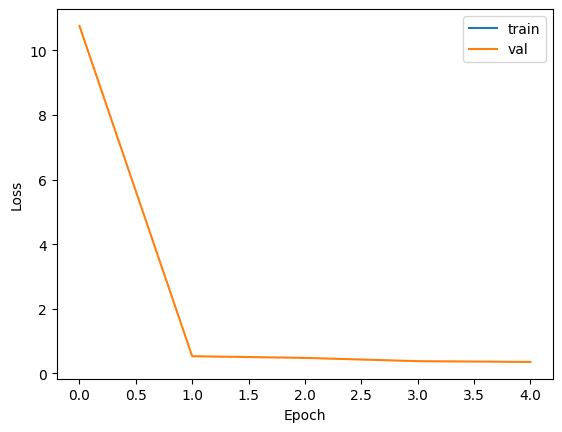

In [ ]:
# with the full dataset this practically converges in 1 epoch
# however I have set to do early stopping which takes about 30 minutes to train
model, train_errors, val_errors, train_times = one_shot(model_func, model_params, run_path, X_train, Y_train, X_val, Y_val,
             optimizier_func=th.optim.Adam, optimizer_params={}, error_func=mean_absolute_percent_error_tensor, minimize_error=True,
             criterion=nn.L1Loss(), patience=10, max_epochs=100, 
             augmentors=None, sample_size=None, device=device, batch_size=batch_size, pytorch_threads=pytorch_threads, num_workers=num_workers, pin_memory=pin_memory,
             checkpoint_freq=0, random_seed=random_seed, mem_optim=True, show_curve=True, show_curve_freq=1,
             x_preproc_func=x_preproc_func, x_preproc_params=x_preproc_params, y_preproc_func=y_preproc_func, y_preproc_params=y_preproc_params,
            )
th.save(model, save_model_to)

# eval model

In [ ]:
# clear up some RAM
del X_train, Y_train

# test data takes a little under X gb of RAM, and a little under 2 minutes to run
X_test = np.load(f'{prepared_datasets_path}rgb_to_depth_v1/test_rgb.npy')
Y_test = np.load(f'{prepared_datasets_path}rgb_to_depth_v1/test_depth.npy')
P_test, predict_time = predict_model(model, device, X_test, Y_test.shape, x_preproc_func=x_preproc_func, x_preproc_params=x_preproc_params, 
                       batch_size=batch_size, pytorch_threads=pytorch_threads, num_workers=num_workers, pin_memory=False,)
P_test = unprocess_func(P_test, **unprocess_params)
evaluations = {
    'r2':r2_score(Y_test, P_test),
    'mape':mean_absolute_percent_error_numpy(Y_test, P_test),
    'predict_time':predict_time,
    'n_epochs':len(train_times)-1,
    'train_time':float(np.sum(train_times)),
}
print(evaluations)
evaluations['train_errors'] = train_errors
evaluations['val_errors'] = val_errors
evaluations['train_times'] = train_times
write_json(evaluations, save_evals_to)

# clear up some RAM
del X_test, Y_test, P_test